In [1]:
import sys

sys.path.append('../')  # go to parent dir

import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

from itertools import chain
from pca_classifier import PCAClassifier

from pylab import rcParams
rcParams['figure.figsize'] = 6, 6

%matplotlib inline

### Load lfw1000 faces database

In [2]:
FACES_DATABASE_FOLDER = '../lfw1000'

face_images = np.array([cv2.imread(os.path.join(FACES_DATABASE_FOLDER, path), cv2.IMREAD_GRAYSCALE)
                        for path
                        in os.listdir(FACES_DATABASE_FOLDER)])

TRAIN_FACES_COUNT = 500
face_images_train = face_images[:TRAIN_FACES_COUNT]
face_images_test = face_images[TRAIN_FACES_COUNT:]

IMAGE_SHAPE = face_images[0].shape

### Explore random faces from lfw1000

##### Define helper function for images visualization

In [3]:
def stack_images(images, cols):
    '''Create one stacked image from smaller with paddings'''
    shape = images[0].shape
    rows = len(images) / cols
    padding = 5
    vert_padding = np.array([255] * shape[0] * padding).reshape((shape[0], padding))
    horiz_width = cols * (shape[1] + padding)
    horiz_padding = np.array([255] * horiz_width * padding).reshape((padding, horiz_width))

    horiz_stacks = np.array([np.hstack([np.hstack((image, vert_padding)) for image in row])
                             for row in
                             np.split(images, rows)])
    stack = np.vstack([np.vstack((row, horiz_padding)) for row in horiz_stacks])
    return stack[0:-padding, 0:-padding]

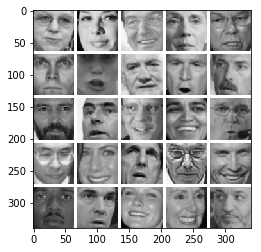

In [4]:
np.random.seed(42)
random_faces = face_images[np.random.randint(0, len(face_images), 25)]
stacked = stack_images(random_faces, 5)

plt.gray()
plt.imshow(stacked)
plt.show()

### Explore random images (not faces) from Cifar-10

In [5]:
def transform_image(image, shape):
    '''Transform cifar-10 rgb image to gray and resize'''
    rgb_image = np.stack([im.reshape((32,32)) for im in np.split(image,3)], axis=2)
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    return cv2.resize(gray_image, shape)

In [6]:
CIFAR_10_FOLDER = '../cifar-10'
CIFAR_10_BATCH = 'data_batch_1'

with open(os.path.join(CIFAR_10_FOLDER, CIFAR_10_BATCH), 'rb') as f:
    cifar_data = pickle.load(f, encoding='bytes')[b'data']

not_face_images = np.array([transform_image(img, IMAGE_SHAPE) for img in cifar_data])

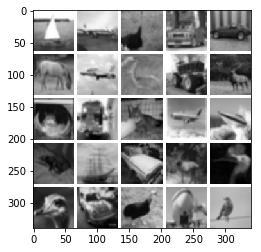

In [7]:
np.random.seed(42)
random_not_faces = not_face_images[np.random.randint(0, len(face_images), 25)]
stacked = stack_images(random_not_faces, 5)

plt.gray()
plt.imshow(stacked)
plt.show()

### Build classifier

In [8]:
clf = PCAClassifier()
clf.fit(face_images_train)

#### Explore mean face

In [9]:
def fix_image(image, shape):
    minimum, maximum = image.min(), image.max()
    image = (image - minimum) / (maximum - minimum) * 255
    return image.astype(np.uint8).reshape(shape)

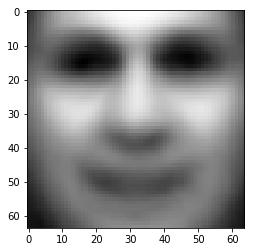

In [10]:
mean_face = fix_image(clf.mean, IMAGE_SHAPE)
plt.imshow(mean_face)
plt.show()

#### Explore top 100 PCA components

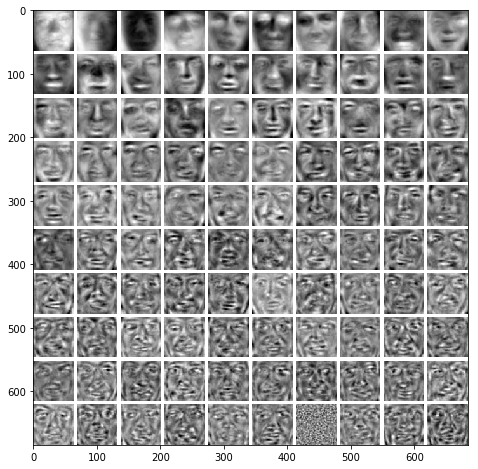

In [11]:
pca_components = np.array([fix_image(img, IMAGE_SHAPE) for img in clf.U.T[:100]])
stacked = stack_images(pca_components, 10)

plt.figure(figsize=(8,8))
plt.imshow(stacked)
plt.show()

### Let's reconstruct a new face in k eigenfaces space for different k

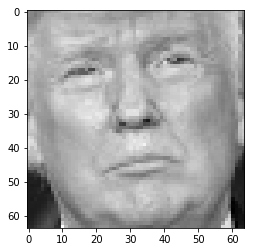

In [12]:
test_image = cv2.resize(cv2.imread(os.path.join('..', 'test.png'), cv2.IMREAD_GRAYSCALE), IMAGE_SHAPE)
plt.imshow(test_image)
plt.show()

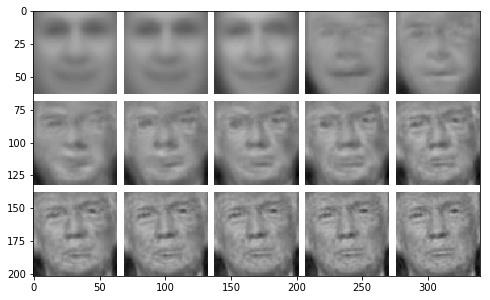

In [13]:
reconstructed_images = []
for k in [1, 2, 5, 10, 20, 40, 60, 80, 100, 150, 200, 250, 300, 400, 500]:
    reconstructed_images.append(clf.reconstruct(test_image, k).reshape(IMAGE_SHAPE))

stacked = stack_images(np.array(reconstructed_images), 5)
plt.figure(figsize=(8, 8))
plt.imshow(stacked)
plt.show()

#### Experimentally (described in report) was found that classifier is most accurate when k=7

True
True
True


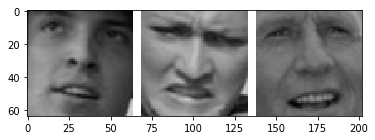

In [14]:
faces = face_images_test[1:4]
for face in faces:
    print(clf.predict(face, 7))
    
plt.imshow(stack_images(faces, 3))
plt.show()

False
False
False


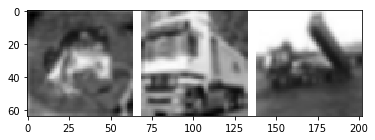

In [15]:
not_faces = not_face_images[0:3]
for img in not_faces:
    print(clf.predict(img, 7))

plt.imshow(stack_images(not_faces, 3))
plt.show()

### Calculate mean residuals of test images for different k

In [16]:
components = list(range(1,501))
face_mean_residuals = []
not_face_mean_residuals = []

for k in components:
    face_mean_residuals.append(np.mean([clf.score(face, k) for face in face_images_test[components]]))
    not_face_mean_residuals.append(np.mean([clf.score(image, k) for image in not_face_images[components]]))

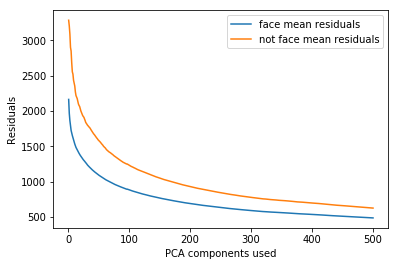

In [17]:
plt.plot(components, face_mean_residuals)
plt.plot(components, not_face_mean_residuals)
plt.legend(['face mean residuals', 'not face mean residuals'])
plt.xlabel('PCA components used')
plt.ylabel('Residuals')
plt.show()